In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

In [4]:
df=pd.read_csv('credit_scoring.csv')

In [5]:
df.head(5)

,ID,Default,Prct_uso_tc,Edad,Nro_prestao_retrasados,Prct_deuda_vs_ingresos,Mto_ingreso_mensual,Nro_prod_financieros_deuda,Nro_retraso_60dias,Nro_creditos_hipotecarios,Nro_retraso_ultm3anios,Nro_dependiente
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
# Handling missing values in 'Mto_ingreso_mensual'
# Option 1: Replace with median
# df['Mto_ingreso_mensual'].fillna(df['Mto_ingreso_mensual'].median(), inplace=True)

# Option 2: Predictive imputation (if preferred)
# Uncomment and use this block for predictive imputation

# Separate rows with and without missing target values
impute_df = df[df['Mto_ingreso_mensual'].notnull()]
predict_df = df[df['Mto_ingreso_mensual'].isnull()]

# Define predictors (drop columns not used for prediction)
X_train = impute_df.drop(['Mto_ingreso_mensual', 'ID', 'Default'], axis=1)
y_train = impute_df['Mto_ingreso_mensual']
X_predict = predict_df.drop(['Mto_ingreso_mensual', 'ID', 'Default'], axis=1)

# Impute missing values in predictors
imputer = SimpleImputer(strategy='mean')  # You can use 'median' or 'most_frequent' instead
X_train = imputer.fit_transform(X_train)
X_predict = imputer.transform(X_predict)

# Train the regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict missing values
predicted_values = reg.predict(X_predict)

# Fill missing values in the original DataFrame
df.loc[df['Mto_ingreso_mensual'].isnull(), 'Mto_ingreso_mensual'] = predicted_values

# Handling missing values in 'Nro_dependiente'
# Replace missing values with median
df['Nro_dependiente'].fillna(df['Nro_dependiente'].median(), inplace=True)

# Verify there are no missing values left
print("Missing Values After Imputation:\n", df.isnull().sum())

Missing Values After Imputation:
 ID                            0
Default                       0
Prct_uso_tc                   0
Edad                          0
Nro_prestao_retrasados        0
Prct_deuda_vs_ingresos        0
Mto_ingreso_mensual           0
Nro_prod_financieros_deuda    0
Nro_retraso_60dias            0
Nro_creditos_hipotecarios     0
Nro_retraso_ultm3anios        0
Nro_dependiente               0
dtype: int64


In [7]:

df['income_bin'] = pd.cut(df['Mto_ingreso_mensual'], bins=[0, 2500, 4800, 7800, 12750, float('inf')], 
                          labels=['Very Low','Low', 'Medium', 'High','Very High'])

df['income_bin'].head()


0         High
1          Low
2          Low
3          Low
4    Very High
Name: income_bin, dtype: category
Categories (5, object): ['Very Low' < 'Low' < 'Medium' < 'High' < 'Very High']

In [8]:
df['income_bin'].unique()

['High', 'Low', 'Very High', 'Very Low', 'Medium', NaN]
Categories (5, object): ['Very Low' < 'Low' < 'Medium' < 'High' < 'Very High']

In [9]:
df_transactions = pd.get_dummies(
    df[['income_bin', 'Default']],
    prefix='', prefix_sep=''
)

df_transactions.head()


,Default,Very Low,Low,Medium,High,Very High
0,1,0,0,0,1,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,1


In [10]:
frequent_itemsets = apriori(df_transactions, min_support=0.005, use_colnames=True)
frequent_itemsets['num_itemsets'] = frequent_itemsets['itemsets'].apply(len)

# Generate rules with even lower confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
# Display the first few rules
rules.head()


/home/u21/fantacher/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Default),(Low),0.06684,0.323480,0.027253,0.40774,1.260479,0.005632,1.142268
1,(Default),(Medium),0.06684,0.314667,0.016967,0.25384,0.806695,-0.004066,0.918480


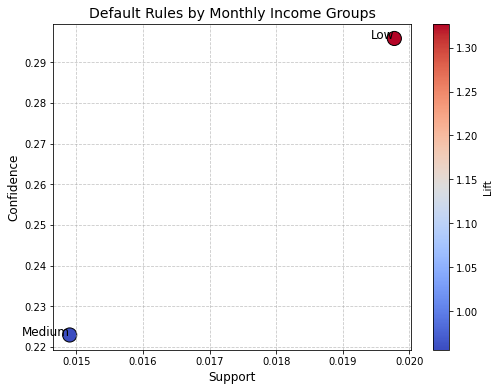

In [11]:
import matplotlib.pyplot as plt

# Prepare data for plotting
income_groups = ['Low', 'Medium']
rules_data_income = [
    {'Income Group': 'Low', 'Support': 0.019773, 'Confidence': 0.295831, 'Lift': 1.327381},
    {'Income Group': 'Medium', 'Support': 0.014900, 'Confidence': 0.222920, 'Lift': 0.955940},
]

# Convert to DataFrame
rules_df_income = pd.DataFrame(rules_data_income)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(rules_df_income['Support'], rules_df_income['Confidence'], c=rules_df_income['Lift'], cmap='coolwarm', s=200, edgecolor='black')
for i, row in rules_df_income.iterrows():
    plt.text(row['Support'], row['Confidence'], row['Income Group'], fontsize=12, ha='right')

# Add labels and color bar
plt.colorbar(label='Lift')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Default Rules by Monthly Income Groups', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('AR_income_group.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


#### Age

In [16]:
# Discretize continuous variables into bins
df['Edad_bin'] = pd.cut(df['Edad'], bins=[29, 49], 
                        labels=['Middle-aged'])
# df['Mto_ingreso_mensual_bin'] = pd.cut(df['Mto_ingreso_mensual'], bins=[0, 5000, 20000, 100000], labels=['Low Income', 'Middle Income', 'High Income'])

# Debug: Check the discretized columns
df[['Edad_bin']].head()


,Edad_bin
0,Middle-aged
1,Middle-aged
2,Middle-aged
3,Middle-aged
4,Middle-aged


In [17]:
df['Edad_bin'].unique()

['Middle-aged', NaN]
Categories (1, object): ['Middle-aged']

In [18]:
# Transform the dataset into a transactional-style format
df_transactions = pd.get_dummies(
    df[['Edad_bin', 'Default']],
    prefix='', prefix_sep=''
)

# Debug: Verify the transaction format|
df_transactions.head()


,Default,Middle-aged
0,1,1
1,0,1
2,0,1
3,0,1
4,0,1


In [19]:
# Apply Apriori with lower thresholds
frequent_itemsets = apriori(df_transactions, min_support=0.005, use_colnames=True)
frequent_itemsets['num_itemsets'] = frequent_itemsets['itemsets'].apply(len)

# Generate rules with even lower confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

# Display the first few rules
rules.head()


/home/u21/fantacher/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Default),(Middle-aged),0.06684,0.383733,0.034753,0.519948,1.354973,0.009105,1.28375


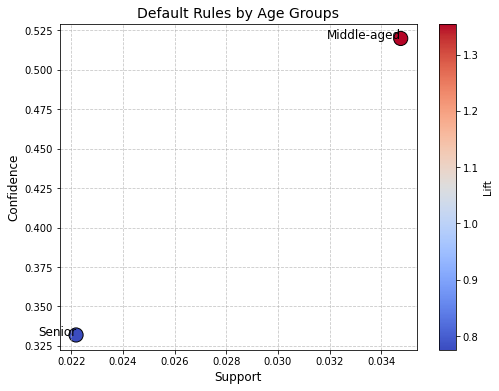

In [20]:
import matplotlib.pyplot as plt

# Prepare data for plotting
age_groups = ['Middle-aged', 'Senior']
rules_data = [
    {'Age Group': 'Middle-aged', 'Support': 0.034754, 'Confidence': 0.519948, 'Lift': 1.354964},
    {'Age Group': 'Senior', 'Support': 0.022187, 'Confidence': 0.331937, 'Lift': 0.775476},
]

# Convert to DataFrame
rules_df = pd.DataFrame(rules_data)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(rules_df['Support'], rules_df['Confidence'], c=rules_df['Lift'], cmap='coolwarm', s=200, edgecolor='black')
for i, row in rules_df.iterrows():
    plt.text(row['Support'], row['Confidence'], row['Age Group'], fontsize=12, ha='right')

# Add labels and color bar
plt.colorbar(label='Lift')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Default Rules by Age Groups', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Ar_age_group.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


In [21]:

# Transform the dataset into a transactional-style format
df_transactions = pd.get_dummies(
    df[['Edad_bin','income_bin', 'Default']],
    prefix='', prefix_sep=''
)

# Debug: Verify the transaction format|
df_transactions.head()

,Default,Middle-aged,Very Low,Low,Medium,High,Very High
0,1,1,0,0,0,1,0
1,0,1,0,1,0,0,0
2,0,1,0,1,0,0,0
3,0,1,0,1,0,0,0
4,0,1,0,0,0,0,1


In [22]:
# Apply Apriori with lower thresholds
frequent_itemsets = apriori(df_transactions, min_support=0.005, use_colnames=True)
frequent_itemsets['num_itemsets'] = frequent_itemsets['itemsets'].apply(len)

# Generate rules with even lower confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

# Display the first few rules
rules.head()


/home/u21/fantacher/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Default),(Middle-aged),0.066840,0.383733,0.034753,0.519948,1.354973,0.009105,1.283750
1,(Default),(Low),0.066840,0.323480,0.027253,0.407740,1.260479,0.005632,1.142268
2,(Default),(Medium),0.066840,0.314667,0.016967,0.253840,0.806695,-0.004066,0.918480
3,(Very Low),(Middle-aged),0.122347,0.383733,0.044793,0.366118,0.954095,-0.002155,0.972211
4,(Low),(Middle-aged),0.323480,0.383733,0.133587,0.412967,1.076183,0.009457,1.049800


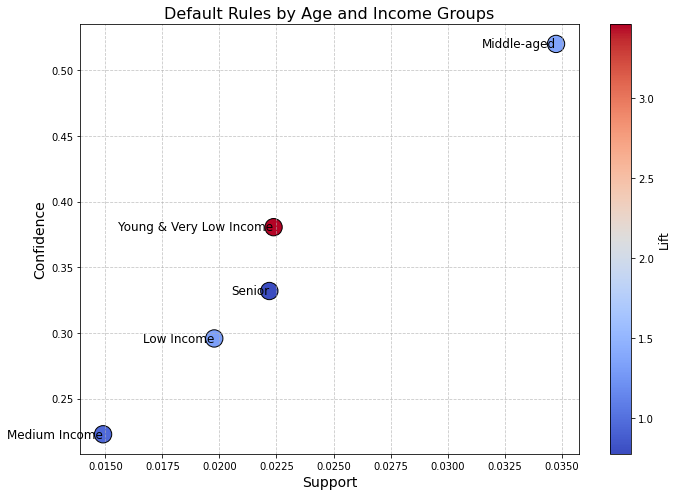

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from rules for Age Groups and Income Levels
rules_data_combined = [
    {'Category': 'Middle-aged', 'Support': 0.034754, 'Confidence': 0.519948, 'Lift': 1.354964},
    {'Category': 'Senior', 'Support': 0.022187, 'Confidence': 0.331937, 'Lift': 0.775476},
    {'Category': 'Low Income', 'Support': 0.019773, 'Confidence': 0.295831, 'Lift': 1.327381},
    {'Category': 'Medium Income', 'Support': 0.014900, 'Confidence': 0.222920, 'Lift': 0.955940},
    {'Category': 'Young & Very Low Income', 'Support': 0.022373, 'Confidence': 0.380499, 'Lift': 3.463886},
]

# Convert to DataFrame
rules_df_combined = pd.DataFrame(rules_data_combined)

# Create scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    rules_df_combined['Support'], 
    rules_df_combined['Confidence'], 
    c=rules_df_combined['Lift'], 
    cmap='coolwarm', 
    s=300, 
    edgecolor='black'
)

# Annotate points with category names
for i, row in rules_df_combined.iterrows():
    plt.text(row['Support'], row['Confidence'], row['Category'], fontsize=12, ha='right', va='center')

# Add color bar for lift values
cbar = plt.colorbar(scatter)
cbar.set_label('Lift', fontsize=12)

# Add axis labels and title
plt.xlabel('Support', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
plt.title('Default Rules by Age and Income Groups', fontsize=16)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('AR_age_income.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()
